In [1]:
import os
import markdown2

readme_paths = []
readme_dir = "/projectnb/ds549/students/mahaveer/ml-549-course/homeworks/fall23_hw1/datasets/readmes"
for docname in os.listdir(readme_dir):
    readme_paths.append(os.path.join(readme_dir,docname))
# print(len(readme_paths))

In [2]:
# load readme contents
readme_contents = []
for path in readme_paths:
    with open(path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = markdown2.markdown(content)
        readme_contents.append(content)
# print(readme_contents[0])

In [3]:
# clean and preprocess the text
import spacy
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import contractions
import inflect

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
custom_stop_words = [
    "karmada", "grpc", "kyverno", "kepler", "longhorn", "antrea", "harbor",
    "istio", "nats", "spiffe", "paralus", "keptn", "openfga", "dapr", "spire",
    "linkerd", "vitess", "chaos", "bye", "opa", "keda", "krustlet", "headlamp",
    "pixie", "zot", "falco", "openebs", "etcd", "strimzi", "parsec", "armada",
    "wasmedge", "akri", "oras", "tikv", "pravega", "openelb", "osm", "crio", "tremor", "argo",
    "werf", "kubevela", "envoy", "oci", "cdk8s", "ko", "bfe", "kpt", "kubernetes",
    
    "secrets", "perf", "nocalhost", "smi", "eraser", "adopted", "meshery",
    "kured", "skooner", "opencost", "k3s", "cortex", "operator", "crd", "cd",
    "trickster",
    
    "jaeger", "ct", "cni", "kudo", "kubeovn", "hwameistor", "limactl", 
    "sh", "kcctl", "updated", "teller", "yes", "mesh", "rook", 
    "collect", "oraslandcli", "codeofconductmd", "tuf", "k8gb"
]
for word in custom_stop_words:
    stop_words.add(word)

def clean_text(input_text):    
    
    # all within square brackets
    clean_text = re.sub(r'\[.*?\]', '', input_text)
    # HTML Tags
    clean_text = re.sub('<[^<]+?>', '', clean_text)
    # URLs and Links
    clean_text = re.sub(r'http\S+', '', clean_text)
    # Lowercase
    clean_text = clean_text.lower()
    # white space
    clean_text = re.sub('\s+', ' ', clean_text)
    # Expand contractions: can't -> cannot
    clean_text = contractions.fix(clean_text)
    # Remove special characters
    clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)
    # Numbers to text
    temp = inflect.engine()
    words = []
    for word in clean_text.split():
        if word.isdigit():
            words.append(temp.number_to_words(word))
        else:
            words.append(word)
    clean_text = ' '.join(words)
    tokens = word_tokenize(clean_text)
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens)
    # Punctuation
    clean_text = re.sub(r'[^\w\s]', '', clean_text)

    return clean_text

processed_readmes = [clean_text(content) for content in readme_contents]


In [4]:
print(processed_readmes[0])

table contents hexa policy orchestrator getting started build hexa image run policy orchestrator application descriptions example workflow getting involved hexa policy orchestrator hexa policy orchestrator enables manage policies consistently across software providers unify access policy management diagram describes current provider architecture getting started hexa project contains three applications policy orchestrator policy translations demo policy administrator demo web application get started running clone download codebase github local machine bash homeworkspace similar git clone gitgithubcomhexaorgpolicyorchestratorgit prerequisites install following dependencies go one hundred twenty pack docker desktop note packages along number supporting software utilities may installed via binpkgdsetupsh additionally setup script run pkg bash cli made available may executed anywhere within repository try pkg help example task build hexa image build hexa image pack newly created image conta

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# document term frequency
count_vectorizer = CountVectorizer(max_df=30)
dtf_matrix = count_vectorizer.fit_transform(processed_readmes)

# tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(dtf_matrix)


In [40]:
from sklearn.decomposition import LatentDirichletAllocation

# lda
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
document_topic_distributions = lda.fit_transform(tfidf_matrix)

# Retrieve top words for each topic
num_top_words = 25  # Adjust as needed
feature_names = tfidf_transformer.get_feature_names_out()
# print(feature_names)

topic_names = []
topic_name_dict = {}
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-num_top_words-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_words = [ count_vectorizer.get_feature_names_out()[int(x[1:]) ] for x in top_words]
    topic_name = f"Topic {topic_idx + 1}: " + ", ".join(top_words)
    topic_names.append(topic_name)
    topic_name_dict[topic_idx] = top_words
    
print('Topics without including the custom stop words')
for name in topic_names:
    print(name)
    
# print(document_topic_distributions)


Topics without including the custom stop words
Topic 1: plugins, stability, located, containerd, tests, kubescape, specification, plugin, component, opengitops, hardware, capsule, containerssh, loadbalancer, manager, engineering, kubevirt, external, custodian, tinkerbell, telepresence, crossplane, events, collector, hub
Topic 2: branch, edge, registry, charts, distribution, keycloak, ingress, video, import, content, backstage, flux, traffic, specification, kuberhealthy, builds, calendar, rust, contour, openyurt, wasmcloud, certmanager, framework, sdk, slides
Topic 3: opentelemetry, specification, proxy, exporter, gt, devstream, volume, gitops, traffic, pushgateway, chart, schemahero, java, controller, authentication, serving, plane, porter, scheduling, pipecd, keylime, devspace, fluid, merbridge, trademarks


In [41]:
custom_topic_names = {
    1: "Containers & Management",
    2: "Software Deployment",
    3: "Observability & Tools"
                      }

In [42]:
# assign topics to each document
document_topics = {}
topics_for_each_document = 1
for doc_idx, doc_topic_dist in enumerate(document_topic_distributions):
    top_topics = doc_topic_dist.argsort()[-topics_for_each_document:]  #top indices
    document_topics[doc_idx+1] = [x for x in top_topics]
# print(document_topics)


In [47]:
#write to a csv file
import pandas as pd
csv_data = {'File Name':[],'Topics':[]}
for i in range(len(readme_paths)):
    csv_data['File Name'].append(readme_paths[i].rsplit('/',1)[-1])
    # csv_data['Topics'].append( custom_topic_names[document_topics[i+1][0]+1] )
    csv_data['Topics'].append( " , ".join([ custom_topic_names[x+1] for x in document_topics[i+1]  ])   )
df = pd.DataFrame(csv_data)
file_name = '/projectnb/ds549/students/mahaveer/ml-549-course/submissions/hw1/document_topics.csv'
df.to_csv(file_name, index=False)



**Visualizations**

Observability & Tools  :  66
Containers & Management  :  53
Software Deployment  :  65


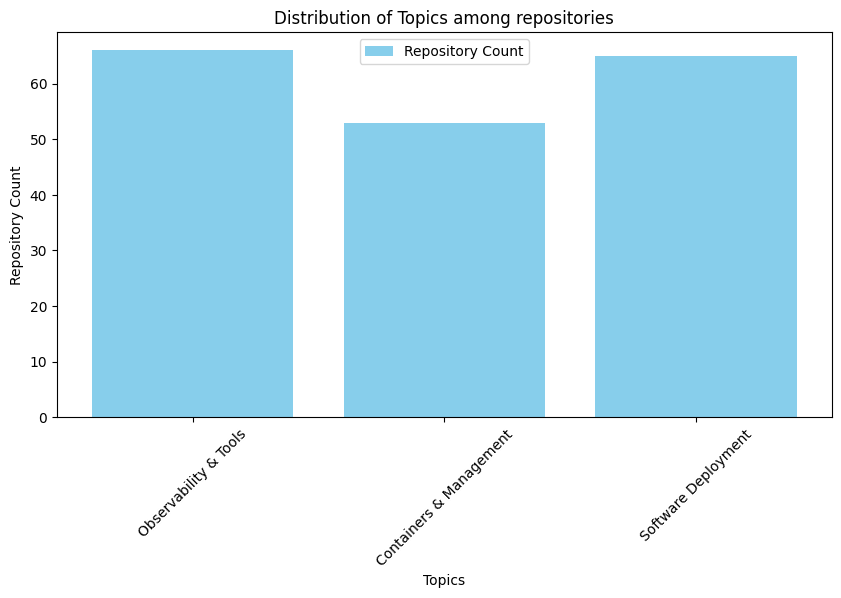

In [45]:
import matplotlib.pyplot as plt
import collections
from collections import Counter

# Given data
data = [ document_topics[idx+1][0] for idx in range(len(readme_paths))]

counter = collections.Counter(data)
x = []
y = []
for k,v in counter.items():
    x.append(custom_topic_names[k+1])
    y.append(v)
    print(x[-1]," : ",y[-1])

plt.figure(figsize=(10, 5))
plt.bar( x, y , color='skyblue')
plt.xlabel('Topics')
plt.xticks(rotation=45)
plt.ylabel('Repository Count')
plt.title('Distribution of Topics among repositories')
plt.legend(['Repository Count'])
plt.show()


In [46]:
import numpy as np
import pyLDAvis


# Get the topic-term distribution and document-topic distributions
topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
doc_topic_dists = lda.transform(dtf_matrix)

terms = count_vectorizer.get_feature_names_out()

# Create the pyLDAvis dataset
vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=dtf_matrix.sum(axis=1).getA1(),
    vocab=terms,
    term_frequency=dtf_matrix.sum(axis=0).getA1(),
    sort_topics=False
)

pyLDAvis.display(vis_data)